In [4]:
import pandas as pd
file_path = '../data/Online_Retail.csv'
df = pd.read_csv(file_path, encoding='unicode_escape')

print("--- First 5 rows of the DataFrame ---")
print(df.head())

print("\n--- Data Types and Nulls per Column (df.info()) ---")
df.info()

--- First 5 rows of the DataFrame ---
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom  

--- Data Types and Nulls per Column (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Nu

In [16]:
print("--- Null Vote Count and Percentages ---")
null_counts = df.isnull().sum()
null_percentages = (null_counts / len(df)) * 100

missing_data = pd.DataFrame({
    'Count' : null_counts,
    'Percentage': null_percentages.round(2)
})

print(missing_data.sort_values(by='Percentage', ascending=False))

--- Null Vote Count and Percentages ---
              Count  Percentage
CustomerID   135080       24.93
Description    1454        0.27
InvoiceNo         0        0.00
StockCode         0        0.00
Quantity          0        0.00
InvoiceDate       0        0.00
UnitPrice         0        0.00
Country           0        0.00


1. Data Governance and Initial Cleaning Decisions
This section addresses key data quality issues identified during the initial diagnostic, specifically focusing on preparing the data for the **RFM Segmentation** which aligns with the business objetive of client retention.

A. Handling Missing Customer IDs (High-Impact Decision)
**Issue:** Approximately **25% of sales records lack a `CustomerID`**.
**Business Impact:** These records cannot be used for critical **retention analysis**, **RFM segmentation**, or calculating **Customer Lifetime Value (CLTV)**, as the buying entity is anonymous.
**Decision Rationale:**
    **For RFM Analysis:** We will **drop** all rows where `CustomerID` is null. This decision ensures the integrity and focus of our client retention strategy
        **For Total Sales/Revenue Analysis:** The original DataFrame (`df`) is retained for reference, ensuring we can still report on total company revenue when needed.

B. Data Type and Integrity Checks
**Issue 1: Dates:** The `InvoiceDate` column is loaded as an `Object` (string) and must be converted to `datetime` to allow for Recency calculations.
**Issue 2: Negative Quantities:** The `Quantity` column contains negative values, which represent **returns or cancellations**. These must be removed from the primary analysis to accurately calculate gross sales and RFM metrics.
**Transformation:** A new column, **`TotalPrice`**, will be calculated as `Quantity * UnitPrice` to represent the total revenue per transaction line, a crucial metric for the 'Monetary' component of RFM.

We will proceed by creating a **clean DataFrame (`df_rfm`)** ready for advanced analytics.

In [5]:
df_rfm = df.dropna(subset=['CustomerID'])

df_rfm['CustomerID'] = df_rfm['CustomerID'].astype(int)

df_rfm['InvoiceDate'] = pd.to_datetime(df_rfm['InvoiceDate'])

df_rfm = df_rfm[df_rfm['Quantity'] > 0]
df_rfm = df_rfm[df_rfm['UnitPrice'] > 0]


df_rfm['TotalPrice'] = df_rfm['Quantity'] * df_rfm['UnitPrice']

print(f"Original Data Size: {len(df)}")
print(f"Clean RFM Data Size: {len(df_rfm)}")
print("\nFinal Data Types Check for RFM Analysis:")
df_rfm.info()

C:\Users\fero\AppData\Local\Temp\ipykernel_13900\34731733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['CustomerID'] = df_rfm['CustomerID'].astype(int)
C:\Users\fero\AppData\Local\Temp\ipykernel_13900\34731733.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_rfm['InvoiceDate'] = pd.to_datetime(df_rfm['InvoiceDate'])


Original Data Size: 541909
Clean RFM Data Size: 397884

Final Data Types Check for RFM Analysis:
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB


C:\Users\fero\AppData\Local\Temp\ipykernel_13900\34731733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['InvoiceDate'] = pd.to_datetime(df_rfm['InvoiceDate'])


In [6]:
# Find the latest date in the dataset to set the reference point.
latest_date = df_rfm['InvoiceDate'].max()
print(f"Latest Transaction Date: {latest_date}")

# Set the reference date as one day after the latest transaction
import datetime as dt
reference_date = latest_date + dt.timedelta(days=1)
print(f"Reference Date for RFM Calculation: {reference_date}")

Latest Transaction Date: 2011-12-09 12:50:00
Reference Date for RFM Calculation: 2011-12-10 12:50:00


In [7]:
# Calculate RFM values for each CustomerID
rfm_df = df_rfm.groupby('CustomerID').agg(
    # Recency (R): Calculate the difference in days between the reference date and the last purchase date
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),

    # Frequency (F): Count the number of unique invoices
    Frequency=('InvoiceNo', 'nunique'),

    # Monetary (M): Sum of the TotalPrice (revenue)
    Monetary=('TotalPrice', 'sum')
)

# Reset index to make CustomerID a regular column for easier visualization later
rfm_df = rfm_df.reset_index()

print("--- Sample of the calculated RFM DataFrame ---")
print(rfm_df.head())
print("\nRFM DataFrame Size:", rfm_df.shape)

--- Sample of the calculated RFM DataFrame ---
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40

RFM DataFrame Size: (4338, 4)


In [8]:
# Create labels for the scores (1-5)
labels = [1, 2, 3, 4, 5]

# --- Calculate R_Score (Recency Score) ---
# We use pd.qcut to divide Recency into 5 equal groups (quintiles)
# IMPORTANT: For Recency, a lower value (e.g., 5 days) is BETTER (score 5).
# So, we reverse the labels: [5, 4, 3, 2, 1]
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# --- Calculate F_Score (Frequency Score) ---
# For Frequency, a higher value (e.g., 10 purchases) is BETTER (score 5).
# We use labels=[1, 2, 3, 4, 5]
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=5, labels=labels, duplicates='drop')

# --- Calculate M_Score (Monetary Score) ---
# For Monetary, a higher value (e.g., $5000) is BETTER (score 5).
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=labels, duplicates='drop')

# Verify the new columns
print("--- RFM DataFrame with Scores ---")
print(rfm_df.head())

--- RFM DataFrame with Scores ---
   CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score
0       12346      326          1  77183.60       1       1       5
1       12347        2          7   4310.00       5       5       5
2       12348       75          4   1797.24       2       4       4
3       12349       19          1   1757.55       4       1       4
4       12350      310          1    334.40       1       1       2


In [9]:
# Combine the scores into a single string (e.g., '555')
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

print("\n--- RFM DataFrame with Combined RFM_Score ---")
print(rfm_df[['CustomerID', 'RFM_Score']].head())


--- RFM DataFrame with Combined RFM_Score ---
   CustomerID RFM_Score
0       12346       115
1       12347       555
2       12348       244
3       12349       414
4       12350       112


Based on the R, F, and M scores, we will group customers into actionable segments. This allows the business to define specific strategies for each group, optimizing marketing spend and retention efforts.

* **Champions (Top Customers):** (Score 555, 545, 554, etc.) Bought recently, buy often, and spent the most.
* **Loyal Customers:** (Score 344, 435, etc.) Buy on a regular basis, good spenders. Responsive to promotions.
* **Potential Loyalists:** (Score 411, 511, 512, etc.) Recent customers, but low frequency or low spend.
* **New Customers:** (Score 511, 411) Bought very recently, but only once.
* **At Risk:** (Score 244, 255, 155, etc.) Used to be high-value customers, but haven't purchased in a long time.
* **Lost:** (Score 111, 121, 211, etc.) Lowest recency, frequency, and monetary scores.

In [10]:
import numpy as np

# Convert R_Score, F_Score, M_Score to integers for comparison
rfm_df['R_Score'] = rfm_df['R_Score'].astype(int)
rfm_df['F_Score'] = rfm_df['F_Score'].astype(int)
rfm_df['M_Score'] = rfm_df['M_Score'].astype(int)

# --- Define Segmentation Conditions ---
# We create a list of conditions (booleans)
conditions = [
    # Champions
    (rfm_df['R_Score'] >= 4) & (rfm_df['F_Score'] >= 4) & (rfm_df['M_Score'] >= 4),
    
    # Loyal Customers (Good R, Good F, Good M, but not champions)
    (rfm_df['R_Score'] >= 3) & (rfm_df['F_Score'] >= 3) & (rfm_df['M_Score'] >= 3),
    
    # At Risk (Used to be good, but low recency)
    (rfm_df['R_Score'] <= 2) & (rfm_df['F_Score'] >= 3) & (rfm_df['M_Score'] >= 3),
    
    # Potential Loyalists / New Customers (Recent, but low F/M)
    (rfm_df['R_Score'] >= 4) & (rfm_df['F_Score'] <= 2) & (rfm_df['M_Score'] <= 2),
    
    # Need Attention (Recent, high spend, but low frequency)
    (rfm_df['R_Score'] >= 4) & (rfm_df['F_Score'] <= 2) & (rfm_df['M_Score'] >= 3),
    
    # Lost (Low R, F, M)
    (rfm_df['R_Score'] <= 2) & (rfm_df['F_Score'] <= 2) & (rfm_df['M_Score'] <= 2)
]

# --- Define Segment Labels ---
# The labels corresponding to the conditions
segment_labels = [
    'Champions',
    'Loyal Customers',
    'At Risk',
    'Potential Loyalists',
    'Need Attention',
    'Lost'
]

# Create the 'Segment' column using np.select
rfm_df['Segment'] = np.select(conditions, segment_labels, default='Other')

# Check the final result
print("--- RFM DataFrame with Business Segments ---")
print(rfm_df[['CustomerID', 'RFM_Score', 'Segment']].head())

--- RFM DataFrame with Business Segments ---
   CustomerID RFM_Score         Segment
0       12346       115           Other
1       12347       555       Champions
2       12348       244         At Risk
3       12349       414  Need Attention
4       12350       112            Lost


C:\Users\fero\AppData\Local\Temp\ipykernel_13900\3032789541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


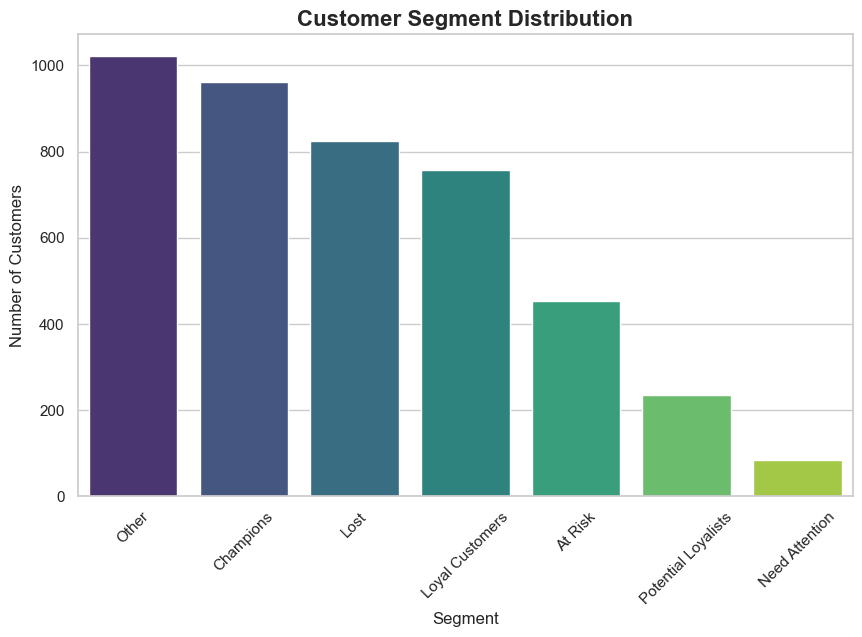

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for the plots
sns.set_theme(style="whitegrid")

# Calculate the count of customers in each segment
segment_counts = rfm_df['Segment'].value_counts().sort_values(ascending=False)

# --- Bar Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')

plt.title('Customer Segment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.show()

C:\Users\fero\AppData\Local\Temp\ipykernel_13900\2466753710.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


Plot saved as Customer_Segment_Distribution.png


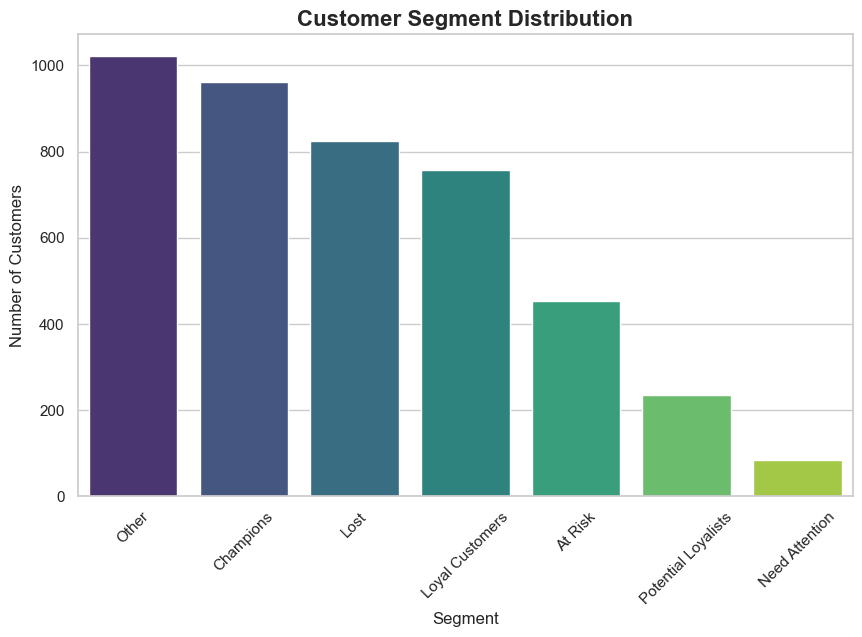

In [12]:
segment_counts = rfm_df['Segment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plot = sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')

plt.title('Customer Segment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)

# Get the figure object from the plot and save it
fig = plot.get_figure()
fig.savefig("Customer_Segment_Distribution.png", bbox_inches='tight') 

print("Plot saved as Customer_Segment_Distribution.png")